# CPSC 066 Final Project: Movie Recommender System with Matrix Factorization Models

**Authors**: Xingyu Dong, Xinxin Li, Luyuan Fan \
**Used Dataset**: [MovieLens](https://grouplens.org/datasets/movielens/) from GroupLens Research Project \
**Used Libraries**: numpy, pandas, matplotlib, sklearn, scikit surpise, scipy \
**Implementation Steps**:
1. Initailize libraries and data
2. Implemention SVD and SVD++
3. Conduct Hyperparameter Tuning
4. Analyze performance

## Initialization

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163745 sha256=bd06dd06c8aed2a1acc8bd056555d67d06640151005a9bcdf21ecd81a43703a1
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD, SVDpp, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import RepeatedKFold
from surprise.model_selection.split import KFold
from matplotlib.patches import Patch

## Data Processing

In [ ]:
# load data from surpise library
data = Dataset.load_builtin('ml-100k')

# convert the data to pandas df to see how it looks like
raw_ratings = [x for x in data.raw_ratings]
ratings_df = pd.DataFrame(raw_ratings, columns=["user", "item", "rating", "timestamp"])
del ratings_df["timestamp"]
ratings_df


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


,user,item,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
...,...,...,...
99995,880,476,3.0
99996,716,204,5.0
99997,276,1090,1.0
99998,13,225,2.0


In [ ]:
ratings_df

,user,item,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
...,...,...,...
99995,880,476,3.0
99996,716,204,5.0
99997,276,1090,1.0
99998,13,225,2.0


In [ ]:
# data processing
trainset, testset = train_test_split(data, test_size=0.25)
train_matrix = np.zeros((trainset.n_users, trainset.n_items))

# matrix with ratings (user by item) --> the IDs are internal IDs
for (uid, iid, rating) in trainset.all_ratings():
    train_matrix[uid, iid] = rating

# create mapping from raw user IDs to inner user IDs
# note: in the code block above where a pandas df is printed, all elements
# are inner ids
raw_to_inner_user = {}
for inner_uid in trainset.all_users():
    raw_user_id = trainset.to_raw_uid(inner_uid)
    raw_to_inner_user[raw_user_id] = inner_uid

# create mapping from raw item IDs to inner item IDs
raw_to_inner_item = {}
for inner_iid in trainset.all_items():
    raw_item_id = trainset.to_raw_iid(inner_iid)
    raw_to_inner_item[raw_item_id] = inner_iid

## Testing Functions

### Accuracy test on dataset

In [ ]:
# func for testing on a testset for our own model
def accuracy_test(model, test, user_diction, item_diction):
    '''
    func for testing on a testset for our own model
    param:
      model - ProbabilisticMatrixFactorizationSVD object
      test - testset, a List, in the form [('raw_user_id', 'raw_item_id', true_rating)]
                          where 'raw_user_id' and 'raw_item_id' are str, true_rating is float
      user_diction - python Dictionary. key: raw id; val: inner id
      item_diction - python Dictionary. key: raw id; val: inner id
    return:
      a list of predictions in the form [(prediction, trueVal)]
    '''
    predictions = []
    for raw_uid, raw_iid, actual_rating in test:
        # convert the raw uid and iid to inner IDs
        inner_uid = user_diction.get(raw_uid)
        inner_iid = item_diction.get(raw_iid)

        # check if both IDs are in the training set
        if inner_uid is not None and inner_iid is not None:
            curr_rating = model.predict(inner_uid, inner_iid)
            predictions.append((curr_rating, actual_rating, inner_uid, inner_iid))
    return predictions

### Test on a single point

In [ ]:
def test_single_point(our_model, library_model, uid_int, iid_int, raw_to_inner_user, raw_to_inner_item):
    #### test on a single point (user - item pair) ####

    # our model
    our_prediction = our_model.predict(uid_int, iid_int)
    print(f"Predicted rating for user '{uid_int}' and item '{iid_int}' using our model:", our_prediction)

    # Convert to corresponding raw IDs for library model predication
    raw_uid = None
    for raw, inner in raw_to_inner_user.items():
        if inner == uid_int:
            raw_uid = raw
            break

    raw_iid = None
    for raw, inner in raw_to_inner_item.items():
        if inner == iid_int:
            raw_iid = raw
            break

    # library model
    library_prediction = library_model.predict(raw_uid, raw_iid)
    print(f"Predicted rating for user '{uid_int}' and item '{iid_int}' using Surprise:", library_prediction.est)

    # true value is 3.0, which can be seen from the pandas df printed at the very top
    # note: randomness is involved in this process so result can vary a lot

### Test on dataset (wrapper)

In [ ]:
def test_dataset(our_model, library_model, raw_to_inner_user, raw_to_inner_item):

    #### test on testset ####

    # predict and test for library
    library_predictions = library_model.test(testset)
    library_rmse = accuracy.rmse(library_predictions, verbose=False)

    # predict and test for ours
    our_predictions = accuracy_test(our_model, testset, raw_to_inner_user, raw_to_inner_item)
    predicted, actual, _, _ = zip(*our_predictions)
    our_rmse = np.sqrt(mean_squared_error(actual, predicted))

    # test results
    print(f'Our RMSE: {our_rmse:.4f}')
    print(f'Surprise SVD Model RMSE: {library_rmse:.4f}')

    # return our_predictions to be used for plotting
    return our_predictions


    # meaning of RMSE: how much on average does our prediction deviates from true val
    # RMSE panelizes large errors more than small errors
    # note: want small RMSE

## Plotting Function

### Residual distribution

In [ ]:
def plot_residual_distribution(actual1, predicted1):
    plt.rcParams.update({'font.size': 14})
    residuals1 = np.array(actual1) - np.array(predicted1)
    # residuals2 = np.array(actual2) - np.array(predicted2)

    plt.figure(figsize=(10, 6))
    # Plotting the first group of residuals
    sns.histplot(residuals1, bins=30, kde=True, color='blue')
    # Plotting the second group of residuals
    # sns.histplot(residuals2, bins=30, kde=True, color='orange', label=label2, alpha=0.7)
    plt.title(f'Residual Distribution for SVD')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Box plot for residual with bin (rating)

In [ ]:
# def box_plot(actual, predicted):
#     plt.rcParams.update({'font.size': 14})
#     residuals = np.array(actual) - np.array(predicted)

#     # use collection's dict to make handling key cases easier
#     bin_to_residual = defaultdict(list)

#     for act, resid in zip(actual, residuals):
#         bin_to_residual[act].append(resid)

#     bins = sorted(bin_to_residual.keys())
#     residual_by_bins = [bin_to_residual[bin] for bin in bins]

#     # box plot
#     plt.figure(figsize=(10, 6))
#     plt.boxplot(residual_by_bins, labels=bins)
#     plt.title('Binned Error Analysis')
#     plt.xlabel('Actual Rating')
#     plt.ylabel('Residuals (Actual - Predicted)')
#     plt.grid(True)
#     plt.show()


def box_plot(actual1, predicted1, actual2, predicted2, label1='Group 1', label2='Group 2'):
    plt.rcParams.update({'font.size': 14})

    def calculate_residuals_and_bin(actual, predicted):
        residuals = np.array(actual) - np.array(predicted)
        bin_to_residual = defaultdict(list)
        for act, resid in zip(actual, residuals):
            bin_to_residual[act].append(resid)
        bins = sorted(bin_to_residual.keys())
        residual_by_bins = [bin_to_residual[bin] for bin in bins]
        return bins, residual_by_bins

    bins1, residual_by_bins1 = calculate_residuals_and_bin(actual1, predicted1)
    bins2, residual_by_bins2 = calculate_residuals_and_bin(actual2, predicted2)

    # Prepare positions for two sets of boxplots
    positions1 = np.arange(len(bins1))
    positions2 = positions1 + 0.4  # Offset positions for the second group

    # Box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(residual_by_bins1, positions=positions1, widths=0.35, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='black'))
    plt.boxplot(residual_by_bins2, positions=positions2, widths=0.35, patch_artist=True, boxprops=dict(facecolor='orange'), medianprops=dict(color='black'))

    plt.xticks(np.arange(len(bins1)) + 0.2, bins1)  # Adjust x-ticks to be in the middle
    plt.title('Binned Error Analysis')
    plt.xlabel('Actual Rating')
    plt.ylabel('Residuals (Actual - Predicted)')
    legend_elements = [Patch(facecolor='blue', label=label1),
                       Patch(facecolor='orange', label=label2)]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(True)
    plt.show()

### Error by residual frequency

In [ ]:
def plot_residuals_by_frequency(freq_dict1, freq_dict2, title, x_label, label1 ='Dataset 1', label2 ='Dataset 2'):
    plt.rcParams.update({'font.size': 14})
    x1, y1, x2, y2 = [], [], [], []

    for freq, res_list in freq_dict1.items():
        x1.extend([freq] * len(res_list))
        y1.extend(res_list)

    for freq, res_list in freq_dict2.items():
        x2.extend([freq] * len(res_list))
        y2.extend(res_list)

    plt.figure(figsize=(12, 6))
    plt.scatter(x1, y1, alpha=0.5, color='blue', label=label1)
    plt.scatter(x2, y2, alpha=0.5, color='orange', label=label2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def plot_residuals_by_frequency_wrapper(our_predictions1, our_predictions2, label1 ='Dataset 1', label2 ='Dataset 2'):
    residuals_with_user_item1 = [(actual - predicted, user, item) for predicted, actual, user, item in our_predictions1]
    residuals_with_user_item2 = [(actual - predicted, user, item) for predicted, actual, user, item in our_predictions2]

    user_rating_count1 = ratings_df.groupby('user').size()
    item_rating_count1 = ratings_df.groupby('item').size()
    user_rating_count2 = ratings_df.groupby('user').size()
    item_rating_count2 = ratings_df.groupby('item').size()

    # key: user & item rating count
    # val: residual
    usercount_to_residuals1 = defaultdict(list)
    itemcount_to_residuals1 = defaultdict(list)
    usercount_to_residuals2 = defaultdict(list)
    itemcount_to_residuals2 = defaultdict(list)

    for residual, user, item in residuals_with_user_item1:
        usercount_to_residuals1[user_rating_count1[user]].append(residual)
        itemcount_to_residuals1[item_rating_count1[item]].append(residual)

    for residual, user, item in residuals_with_user_item2:
        usercount_to_residuals2[user_rating_count2[user]].append(residual)
        itemcount_to_residuals2[item_rating_count2[item]].append(residual)

    plot_residuals_by_frequency(usercount_to_residuals1, usercount_to_residuals2, 'Error by User Rating Frequency', 'Number of Ratings by User', "SVD", "SVD++")
    plot_residuals_by_frequency(itemcount_to_residuals1, itemcount_to_residuals2, 'Error by Item Rating Frequency', 'Number of Ratings for Item', "SVD", "SVD++")

## SVD

### Model Definition

In [ ]:
class ProbabilisticMatrixFactorizationSVD:

    def __init__(self, num_factors=10, num_epochs=50, learning_rate=0.01, reg=0.1):
        self.num_factors = num_factors
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.reg = reg


    def initialize_with_dataset(self, R):
        self.R = R
        self.num_users, self.num_items = R.shape

        # initialize user/item factors
        # np.random.seed(42)
        self.user_factors = np.random.normal(scale=0.1, size=(self.num_users, self.num_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(self.num_items, self.num_factors))

        # initialize bias
        self.global_bias = np.mean(R[np.where(R != 0)])
        self.user_bias = np.zeros(self.num_users)
        self.item_bias = np.zeros(self.num_items)

        for i in range(self.num_users):
          user_ratings = R[i, np.where(R[i, :] != 0)]
          if len(user_ratings) > 0:
              self.user_bias[i] = np.mean(user_ratings) - self.global_bias
          else:
              self.user_bias[i] = 0.

        for j in range(self.num_items):
          item_ratings = R[np.where(R[:, j] != 0), j]
          if len(item_ratings[0]) > 0:
              self.item_bias[j] = np.mean(item_ratings) - self.global_bias
          else:
              self.item_bias[j] = 0.


    def fit(self, R, biased =True):
        self.initialize_with_dataset(R)

        # training process
        for epoch in range(self.num_epochs):
            for i in range(self.num_users):
                for j in range(self.num_items):
                    if self.R[i, j] > 0:
                        # calculate error
                        prediction = self.predict(i, j)
                        error = self.R[i, j] - prediction

                        # update factors and biases
                        self.user_factors[i, :] += self.learning_rate * (error * self.item_factors[j, :] - self.reg * self.user_factors[i, :])
                        self.item_factors[j, :] += self.learning_rate * (error * self.user_factors[i, :] - self.reg * self.item_factors[j, :])
                        if biased:
                            self.user_bias[i] += self.learning_rate * (error - self.reg * self.user_bias[i])
                            self.item_bias[j] += self.learning_rate * (error - self.reg * self.item_bias[j])


    def predict(self, user, item, biased =True):
        if biased:
            prediction_base = self.global_bias + self.user_bias[user] + self.item_bias[item]
        else:
            prediction_base = 0
        return prediction_base + self.user_factors[user, :].dot(self.item_factors[item, :].T)


### Fitting with data

In [ ]:
# initialize and train our model
our_model = ProbabilisticMatrixFactorizationSVD(num_factors=10, num_epochs=20, learning_rate=0.01, reg=0.1)
our_model.fit(train_matrix)

# initialize and train library model
library_model = SVD(n_factors=10, n_epochs=20, lr_all = 0.01, reg_all = 0.1)
library_model.fit(trainset)

### Testing

In [ ]:
#### test on a single point (user - item pair) ####
# make prediction (rating) for user '196' and item '242'

print('-------')
print('Testing on user 196 and item 242:')
test_single_point(our_model, library_model, 196, 242, raw_to_inner_user, raw_to_inner_item)

print('-------')
print('Testing on the dataset')
our_predictions = test_dataset(our_model, library_model, raw_to_inner_user, raw_to_inner_item)

predicted, actual, inner_uid, inner_iid = zip(*our_predictions)

-------
Testing on user 196 and item 242:
Predicted rating for user '196' and item '242' using our model: 2.653657805223046
Predicted rating for user '196' and item '242' using Surprise: 2.7133954218562306
-------
Testing on the dataset
Our RMSE: 0.9336
Surprise SVD Model RMSE: 0.9315


### Analysis with plotting

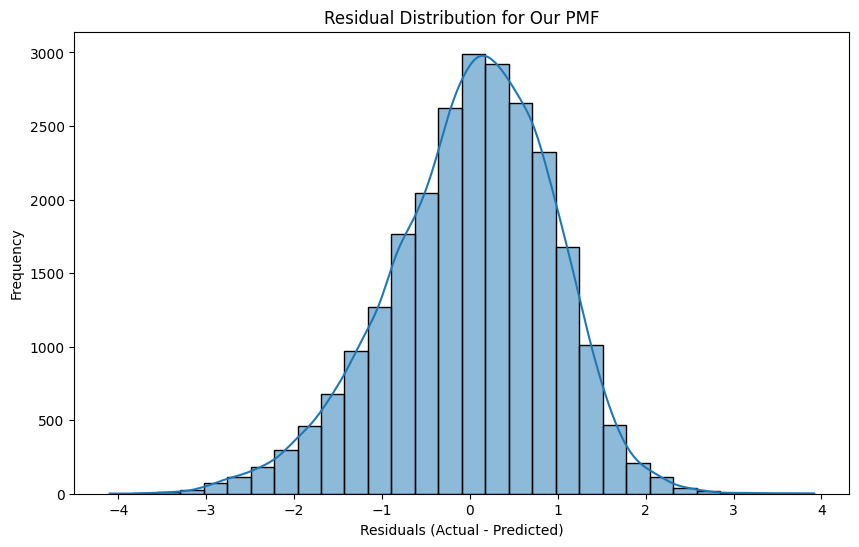

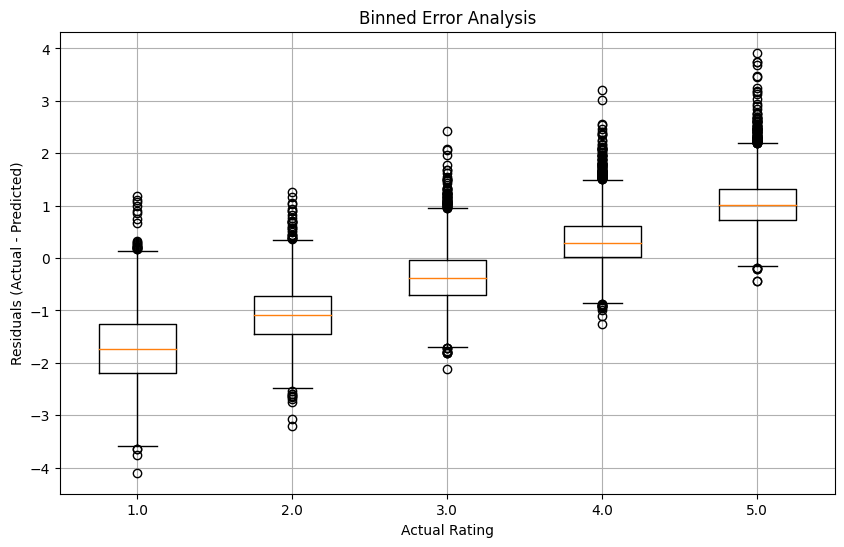

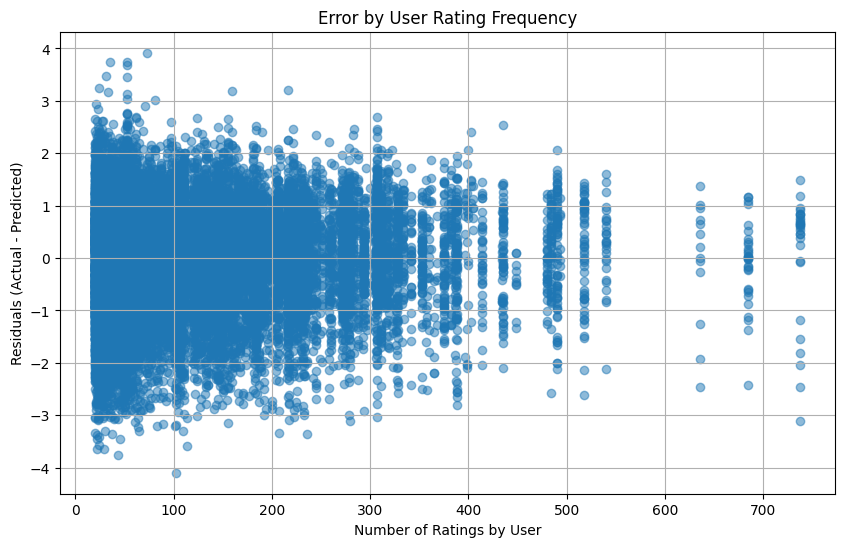

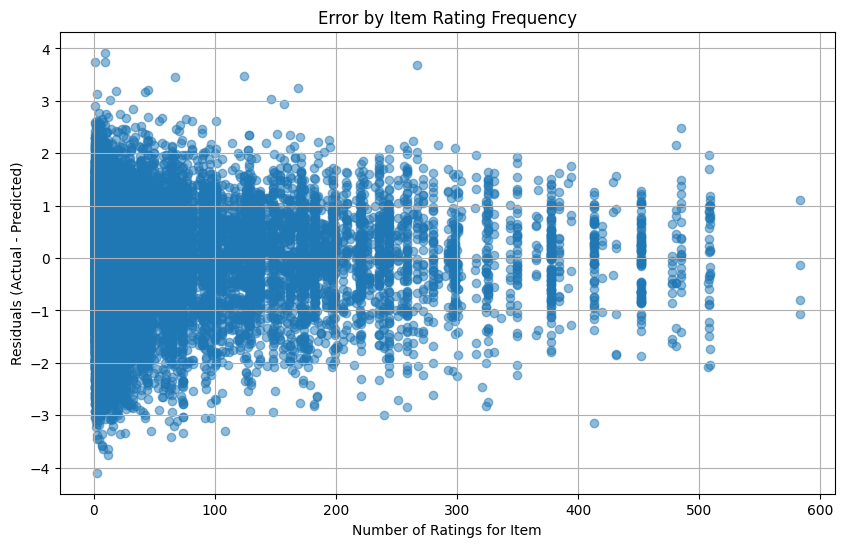

In [ ]:
plot_residual_distribution(actual, predicted)
box_plot(actual, predicted)
plot_residuals_by_frequency_wrapper(our_predictions)

## SVD++

### Model Definition

In [ ]:
class ProbabilisticMatrixFactorizationSVDPP:

    def __init__(self, num_factors=10, num_epochs=50, learning_rate=0.01, reg=0.1):
        self.num_factors = num_factors
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.reg = reg


    def initialize_with_dataset(self, R):
        self.R = R
        self.num_users, self.num_items = R.shape

        # initialize user/item/implicit factors
        # np.random.seed(42)
        self.user_factors = np.random.normal(scale=0.1, size=(self.num_users, self.num_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(self.num_items, self.num_factors))
        self.implicit_factors = np.random.normal(scale=0.1, size=(self.num_items, self.num_factors))

        # initialize bias
        self.global_bias = np.mean(R[np.where(R != 0)])
        self.user_bias = np.zeros(self.num_users)
        self.item_bias = np.zeros(self.num_items)

        for i in range(self.num_users):
          user_ratings = R[i, np.where(R[i, :] != 0)]
          if len(user_ratings) > 0:
              self.user_bias[i] = np.mean(user_ratings) - self.global_bias
          else:
              self.user_bias[i] = 0.

        for j in range(self.num_items):
          item_ratings = R[np.where(R[:, j] != 0), j]
          if len(item_ratings[0]) > 0:
              self.item_bias[j] = np.mean(item_ratings) - self.global_bias
          else:
              self.item_bias[j] = 0.


    def fit(self, R, biased =True):
        self.initialize_with_dataset(R)

        # training process
        for epoch in range(self.num_epochs):
            for i in range(self.num_users):
                # print(f'user {i}')
                # calculate implicit feedback for user i
                # sqrt_Ru = np.sqrt(len(self.R[i, :] > 0))
                # sum_yj = np.sum(self.implicit_factors[self.R[i, :] > 0, :], axis=0)
                # impl_feed = None

                # if sqrt_Ru > 0:
                #     impl_feed = sum_yj / sqrt_Ru
                # else:
                #     impl_feed = np.zeros(self.num_factors)

                for j in range(self.num_items):
                    if self.R[i, j] > 0:
                        # calculate error
                        prediction, sqrt_Ru, impl_feed = self.predict(i, j, return_extra=True)
                        error = self.R[i, j] - prediction

                        # update factors and biases
                        self.item_factors[j, :] += self.learning_rate * (error * (self.user_factors[i, :] + impl_feed) - self.reg * self.item_factors[j, :])
                        self.user_factors[i, :] += self.learning_rate * (error * self.item_factors[j, :] - self.reg * self.user_factors[i, :])
                        if biased:
                            self.user_bias[i] += self.learning_rate * (error - self.reg * self.user_bias[i])
                            self.item_bias[j] += self.learning_rate * (error - self.reg * self.item_bias[j])

                        # update implicit factor
                        for k in np.where(self.R[i, :] > 0)[0]:
                            self.implicit_factors[k, :] += self.learning_rate * (error * self.item_factors[j, :] / sqrt_Ru - self.reg * self.implicit_factors[k, :])

    def predict(self, user, item, biased =True, return_extra =False):
        # calculate implicit feedback for user i
        sqrt_Ru = np.sqrt(len(self.R[user, :] > 0))
        sum_yj = np.sum(self.implicit_factors[self.R[user, :] > 0, :], axis=0)
        impl_feed = None

        if sqrt_Ru > 0:
            impl_feed = sum_yj / sqrt_Ru
        else:
            impl_feed = np.zeros(self.num_factors)

        if biased:
            prediction_base = self.global_bias + self.user_bias[user] + self.item_bias[item]
        else:
            prediction_base = 0
        if return_extra:
            return prediction_base + (self.user_factors[user, :] + impl_feed).dot(self.item_factors[item, :].T), sqrt_Ru, impl_feed
        return prediction_base + (self.user_factors[user, :] + impl_feed).dot(self.item_factors[item, :].T)


### Fitting with data

In [ ]:
# initialize and train our model
our_svdpp_model = ProbabilisticMatrixFactorizationSVDPP(num_factors=10, num_epochs=20, learning_rate=0.01, reg=0.1)
our_svdpp_model.fit(train_matrix)

# initialize and train library model
library_model = SVDpp(n_factors=10, n_epochs=20, lr_all = 0.01, reg_all = 0.1, random_state = 42)
library_model.fit(trainset)

### Testing

In [ ]:
#### test on a single point (user - item pair) ####
# make prediction (rating) for user '196' and item '242'

print('-------')
print('Testing on user 196 and item 242:')
test_single_point(our_svdpp_model, library_model, 196, 242, raw_to_inner_user, raw_to_inner_item)

print('-------')
print('Testing on the dataset')
our_predictions = test_dataset(our_svdpp_model, library_model, raw_to_inner_user, raw_to_inner_item)

predicted, actual, inner_uid, inner_iid = zip(*our_predictions)

-------
Testing on user 196 and item 242:
Predicted rating for user '196' and item '242' using our model: 4.732303963443464
Predicted rating for user '196' and item '242' using Surprise: 4.627844386257993
-------
Testing on the dataset
Our RMSE: 0.9379
Surprise SVD Model RMSE: 0.9251


### Analysis with plotting

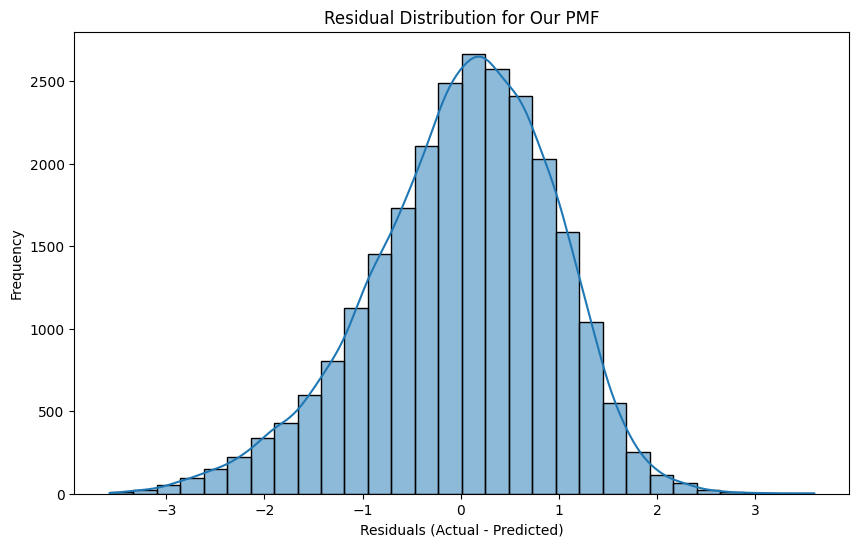

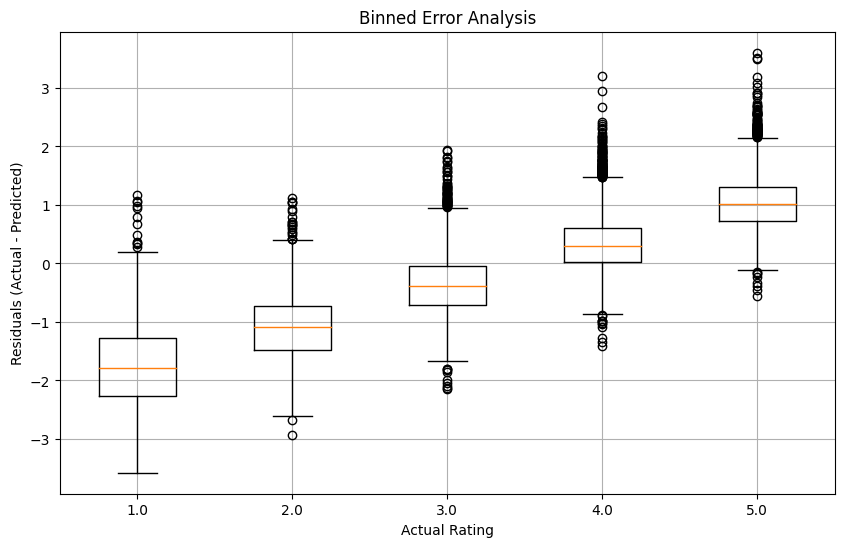

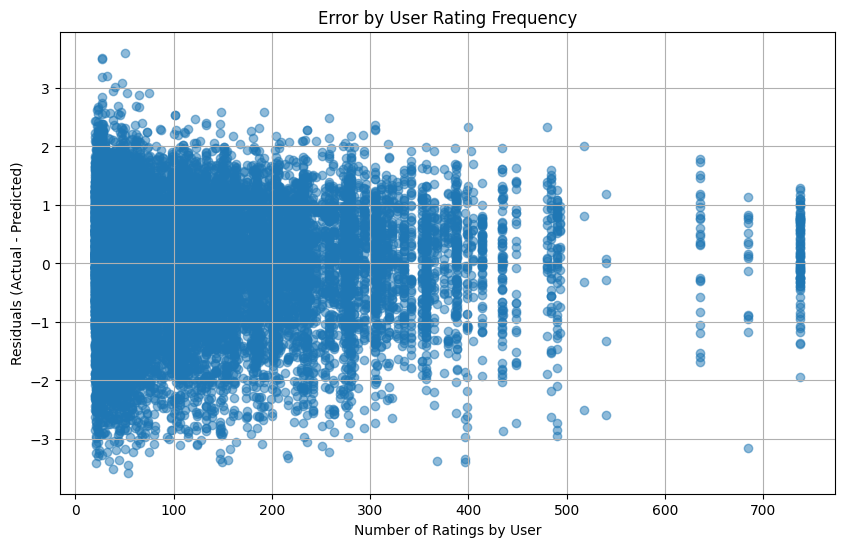

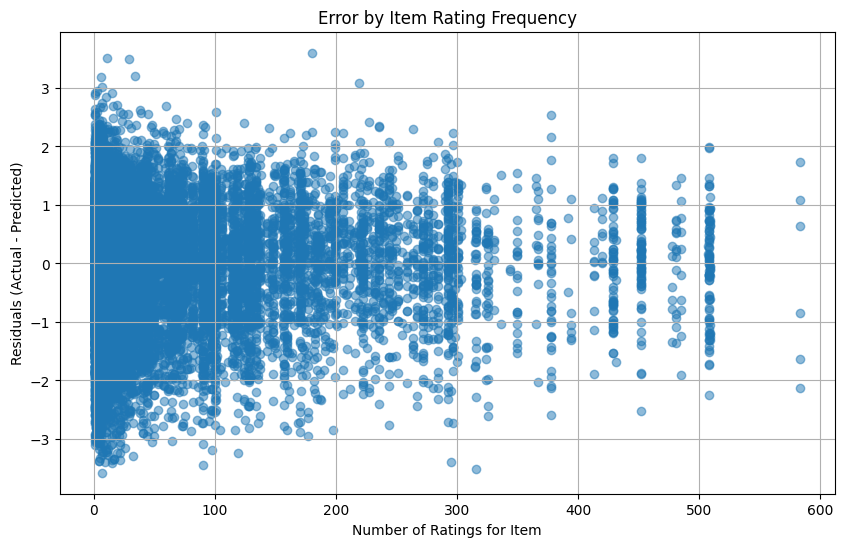

In [ ]:
plot_residual_distribution(actual, predicted)
box_plot(actual, predicted)
plot_residuals_by_frequency_wrapper(our_predictions)

## Hyperparameter-Tuning

Hyperparameter Tunning on SVD method; varying:
- number of (implicit) factors: 5, 10, 15
- learning rate: 0,001, 0.01, 0.05
- regulization factor: 0.1, 0.3, 0.5

In [ ]:
# Hyperparameter grid
param_grid = {
    'num_factors': [5, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05],
    'reg': [0.1, 0.3, 0.5]
}

In [ ]:
def hyperparamTuning(param_grid, k =5, model_choice ='SVD'):

    kf = KFold(n_splits=5, shuffle=True)

    best_params = None
    best_score = float('inf')

    for factor in param_grid['num_factors']:
        for lr in param_grid['learning_rate']:
            for reg in param_grid['reg']:
                print()
                print()
                print('--------')
                print('num_factors:', factor, ' learning_rate:', lr, ' reg:', reg)
                print()
                rmses = []
                foldcount = 1
                for trainset, testset in kf.split(data):
                    print('in fold', foldcount)

                    train_matrix = np.zeros((trainset.n_users, trainset.n_items))

                    # matrix with ratings (user by item) --> the IDs are internal IDs
                    for (uid, iid, rating) in trainset.all_ratings():
                        train_matrix[uid, iid] = rating

                    # create mapping from raw user IDs to inner user IDs
                    # note: in the code block above where a pandas df is printed, all elements
                    # are inner ids
                    raw_to_inner_user = {}
                    for inner_uid in trainset.all_users():
                        raw_user_id = trainset.to_raw_uid(inner_uid)
                        raw_to_inner_user[raw_user_id] = inner_uid

                    # create mapping from raw item IDs to inner item IDs
                    raw_to_inner_item = {}
                    for inner_iid in trainset.all_items():
                        raw_item_id = trainset.to_raw_iid(inner_iid)
                        raw_to_inner_item[raw_item_id] = inner_iid

                    # initialize model with current set of hyperparameters
                    if model_choice == 'SVD':
                        model = ProbabilisticMatrixFactorizationSVD(num_factors=factor, num_epochs=20, learning_rate=lr, reg=reg)
                    elif model_choice == 'SVD++':
                        model = ProbabilisticMatrixFactorizationSVDPP(num_factors=factor, num_epochs=20, learning_rate=lr, reg=reg)
                    else:
                        print('Error: please choose from SVD and SVD++')
                        return None
                    model.fit(train_matrix)

                    # evaluate the model
                    predictions = accuracy_test(model, testset, raw_to_inner_user, raw_to_inner_item)
                    predicted, actual, _, _ = zip(*predictions)
                    rmse = np.sqrt(mean_squared_error(actual, predicted))

                    rmses.append(rmse)

                    print('fold', foldcount, 'RMSE: ', rmse)
                    foldcount += 1
                    print()

                avg_score = np.mean(rmses)

                print()
                print('average RMSE:', avg_score)
                print('--------')

                # note: best_score should be the smallest RMSE
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {'num_factors': factor, 'learning_rate': lr, 'reg': reg}

    print("Best Parameters:", best_params)
    return best_params

In [ ]:
# tune SVD
svd_param = hyperparamTuning(param_grid, model_choice='SVD')


# tune SVD++
svdpp_param = hyperparamTuning(param_grid, model_choice='SVD++')

## Analysis using best params

### SVD

In [ ]:
tuning_results = {
    (5, 0.01, 0.1): 0.9374559771984586,
    (5, 0.01, 0.3): 0.9543470498135834,
    (5, 0.01, 0.5): 0.9644951119728964,
    (5, 0.03, 0.1): 0.930479638326719,
    (5, 0.03, 0.3): 0.9644467583962356,
    (5, 0.03, 0.5): 0.9748150898363906,
    (5, 0.05, 0.1): 0.9466150253600245,
    (5, 0.05, 0.3): 0.9742600073670603,
    (5, 0.05, 0.5): 0.9834930319430889,
    (10, 0.01, 0.1): 0.9357296439093113,
    (10, 0.01, 0.3): 0.9532534428914146,
    (10, 0.01, 0.5): 0.9645778210626016,
    (10, 0.03, 0.1): 0.929209371223015,
    (10, 0.03, 0.3): 0.9652208889370444,
    (10, 0.03, 0.5): 0.9748400961398049,
    (10, 0.05, 0.1): 0.9476278144620339,
    (10, 0.05, 0.3): 0.9744357404243342,
    (10, 0.05, 0.5): 0.9868554198684898,
    (15, 0.01, 0.1): 0.9329823815972202,
    (15, 0.01, 0.3): 0.9536741755491274,
    (15, 0.01, 0.5): 0.9646921399441777,
    (15, 0.03, 0.1): 0.9279491782721054,
    (15, 0.03, 0.3): 0.96297083725819,
    (15, 0.03, 0.5): 0.9739740426587533,
    (15, 0.05, 0.1): 0.949163845941289,
    (15, 0.05, 0.3): 0.973181602616614,
    (15, 0.05, 0.5): 0.9829737512295204
}


<ipython-input-16-d11ce8a20020>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  nfact_lr_pivot = nfact_lr.pivot("num_factors", "learning_rate", "RMSE")


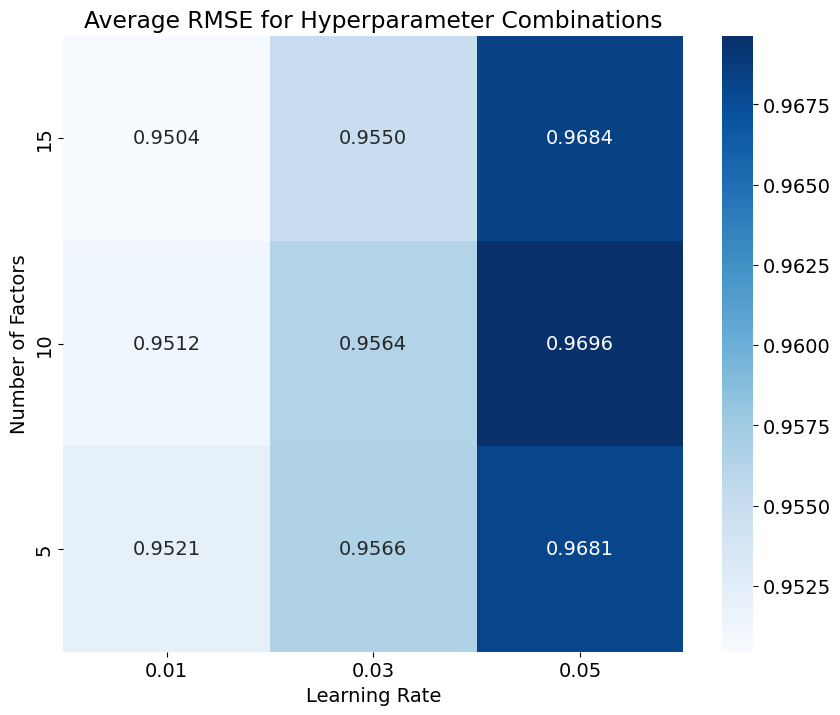

<ipython-input-16-d11ce8a20020>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  reg_lr_pivot = reg_lr.pivot("reg", "learning_rate", "RMSE")


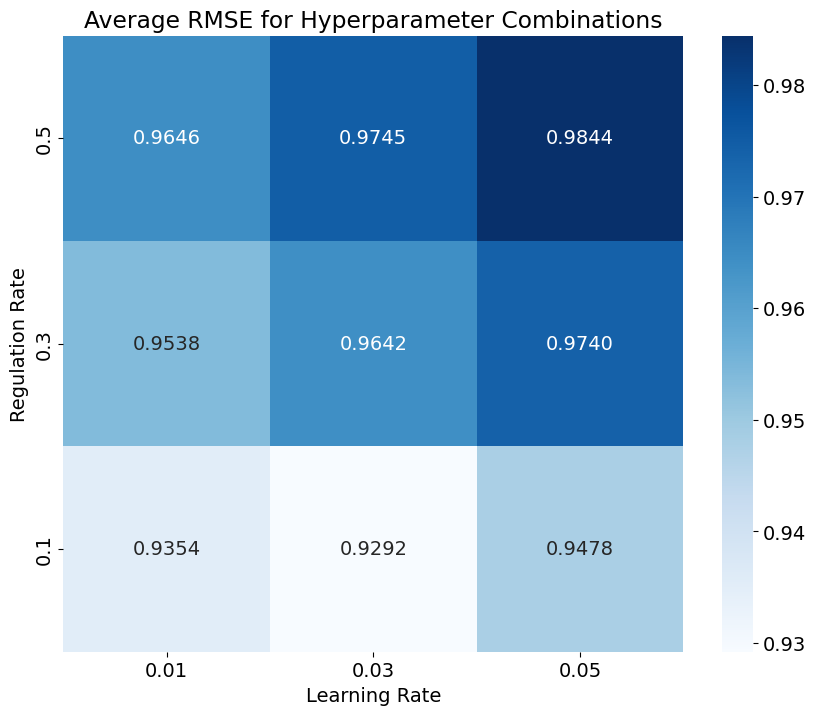

<ipython-input-16-d11ce8a20020>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  nfact_reg_pivot = nfact_reg.pivot("num_factors", "reg", "RMSE")


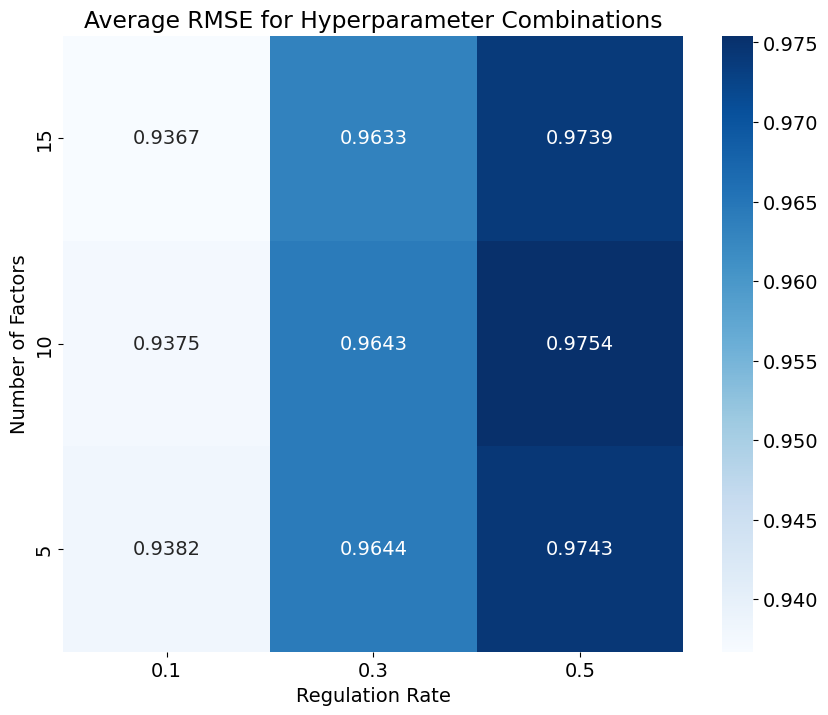

In [ ]:
tuning_results_df = pd.DataFrame([
    {'num_factors': num_factors, 'learning_rate': learning_rate, 'reg': reg, 'RMSE': rmse}
    for (num_factors, learning_rate, reg), rmse in tuning_results.items()
])

nfact_lr = tuning_results_df.groupby(['num_factors', 'learning_rate']).RMSE.mean().reset_index()

nfact_lr_pivot = nfact_lr.pivot("num_factors", "learning_rate", "RMSE")

plt.rcParams.update({'font.size': 14})

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nfact_lr_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Number of Factors")
plt.xlabel("Learning Rate")
plt.show()

reg_lr = tuning_results_df.groupby(['reg', 'learning_rate']).RMSE.mean().reset_index()

reg_lr_pivot = reg_lr.pivot("reg", "learning_rate", "RMSE")

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(reg_lr_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Regulation Rate")
plt.xlabel("Learning Rate")
plt.show()

nfact_reg = tuning_results_df.groupby(['num_factors', 'reg']).RMSE.mean().reset_index()

nfact_reg_pivot = nfact_reg.pivot("num_factors", "reg", "RMSE")

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nfact_reg_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Number of Factors")
plt.xlabel("Regulation Rate")
plt.show()

Our RMSE: 0.9281
Surprise SVD Model RMSE: 0.9217


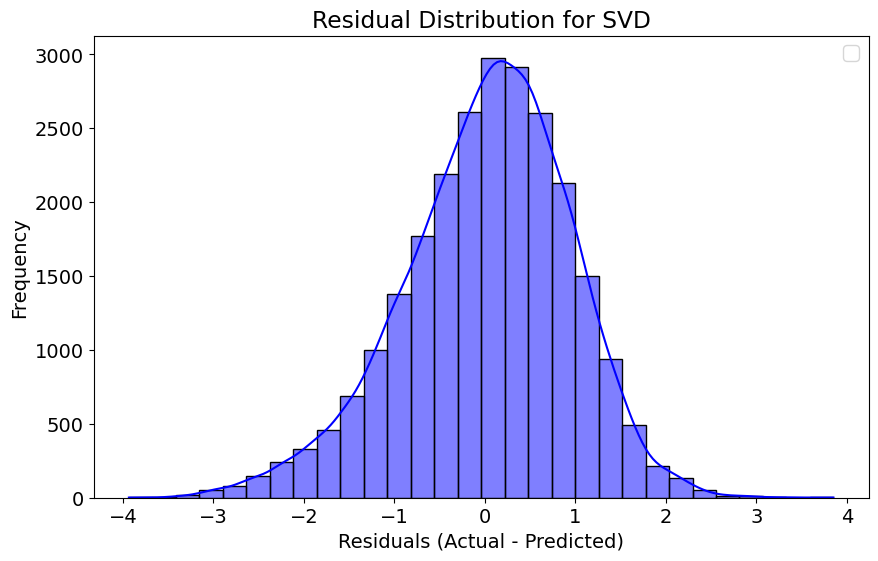

In [ ]:
svd_param = {
    'num_factors': 15,
    'learning_rate': 0.03,
    'reg': 0.1
}

# initialize and train our model
our_model = ProbabilisticMatrixFactorizationSVD(num_factors=svd_param['num_factors'], num_epochs=20, learning_rate=svd_param['learning_rate'], reg=svd_param['reg'])
our_model.fit(train_matrix)

# initialize and train library model
library_model = SVD(n_factors=svd_param['num_factors'], n_epochs=20, lr_all = svd_param['learning_rate'], reg_all = svd_param['reg'])
library_model.fit(trainset)

our_predictions = test_dataset(our_model, library_model, raw_to_inner_user, raw_to_inner_item)

predicted, actual, inner_uid, inner_iid = zip(*our_predictions)

plot_residual_distribution(actual, predicted)

### SVD++

In [ ]:
tuning_results_pp = {
    (5, 0.01, 0.1): 0.9390970862235916,
    (5, 0.01, 0.3): 0.9538746535360316,
    (5, 0.01, 0.5): 0.9643224330205606,
    (5, 0.03, 0.1): 0.9301305609781363,
    (5, 0.03, 0.3): 0.9632456785969618,
    (5, 0.03, 0.5): 0.9730671237295981,
    (5, 0.05, 0.1): 0.9455664348917209,
    (5, 0.05, 0.3): 0.9751021835498686,
    (5, 0.05, 0.5): 0.9855958655358965,
    (10, 0.01, 0.1): 0.9343680689372995,
    (10, 0.01, 0.3): 0.9535736546040953,
    (10, 0.01, 0.5): 0.9642411709357388,
    (10, 0.03, 0.1): 0.9301352703374025,
    (10, 0.03, 0.3): 0.964752056068191,
    (10, 0.03, 0.5): 0.974106419943892,
    (10, 0.05, 0.1): 0.9478849906429427,
    (10, 0.05, 0.3): 0.9735367814476227,
    (10, 0.05, 0.5): 0.9840559580483855,
    (15, 0.05, 0.1): 0.9458706433166494,
    (15, 0.05, 0.3): 0.9761293932050922,
    (15, 0.05, 0.5): 0.9851242617006555,
    (15, 0.03, 0.1): 0.9290332731006261,
    (15, 0.03, 0.3): 0.9626089027644049,
    (15, 0.03, 0.5): 0.9762501668829788,
    (15, 0.01, 0.1): 0.9315604458473323,
    (15, 0.01, 0.3): 0.9543330093648412,
    (15, 0.01, 0.5): 0.9644983791402026
}


<ipython-input-18-653906c10fb0>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  nfact_lr_pivot = nfact_lr.pivot("num_factors", "learning_rate", "RMSE")


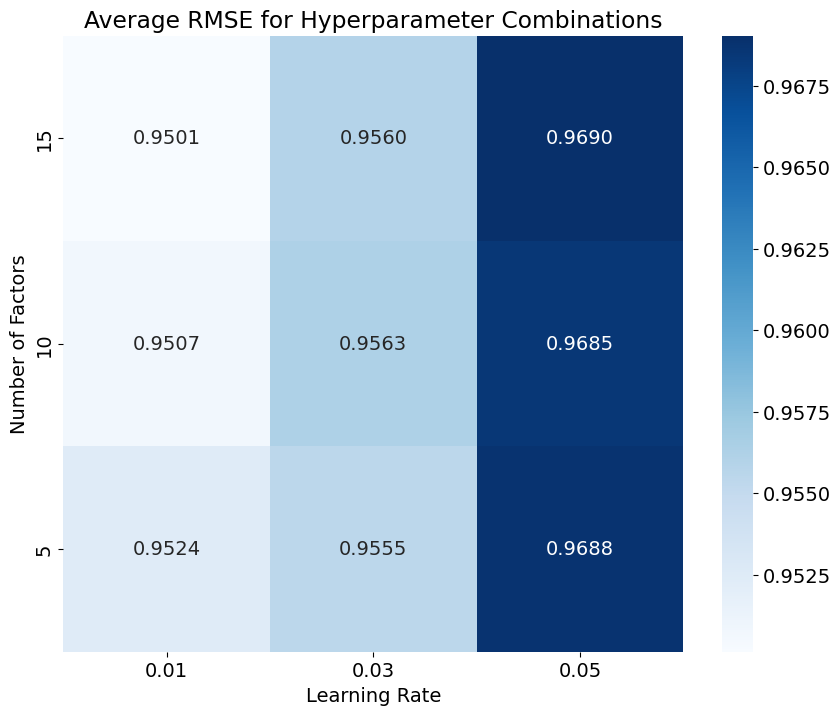

<ipython-input-18-653906c10fb0>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  reg_lr_pivot = reg_lr.pivot("reg", "learning_rate", "RMSE")


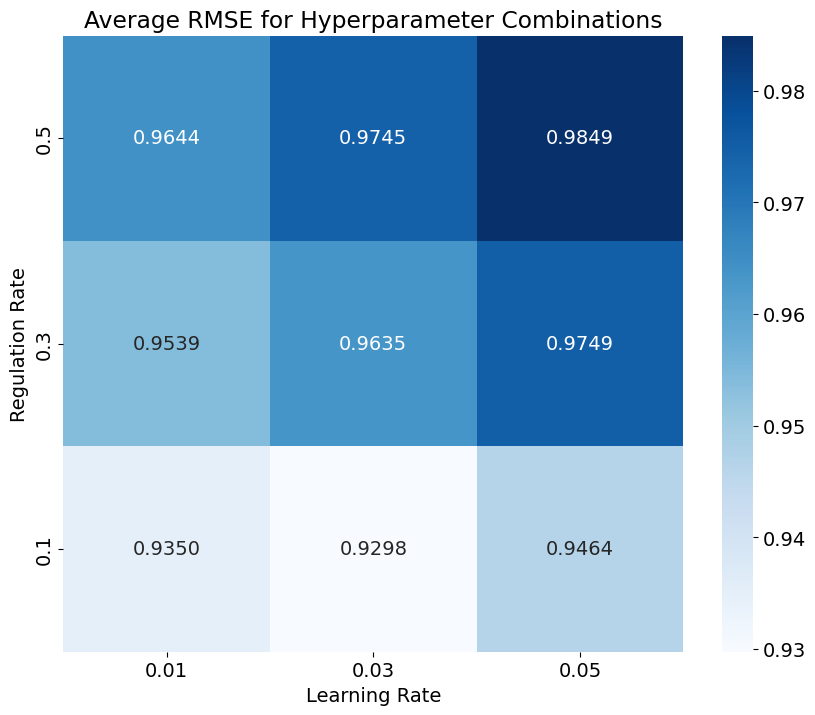

<ipython-input-18-653906c10fb0>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  nfact_reg_pivot = nfact_reg.pivot("num_factors", "reg", "RMSE")


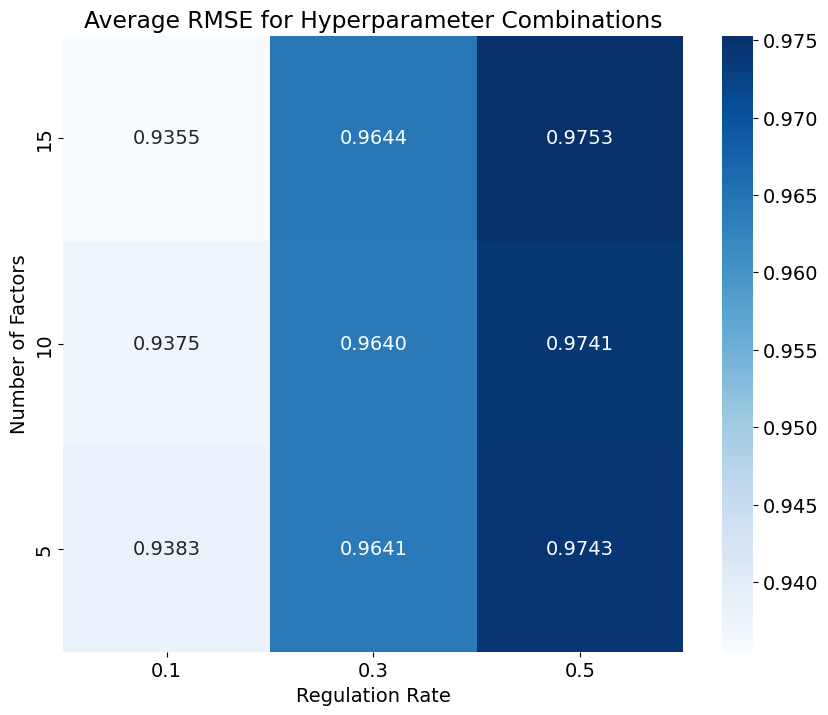

In [ ]:
tuning_results_df = pd.DataFrame([
    {'num_factors': num_factors, 'learning_rate': learning_rate, 'reg': reg, 'RMSE': rmse}
    for (num_factors, learning_rate, reg), rmse in tuning_results_pp.items()
])

nfact_lr = tuning_results_df.groupby(['num_factors', 'learning_rate']).RMSE.mean().reset_index()

nfact_lr_pivot = nfact_lr.pivot("num_factors", "learning_rate", "RMSE")

plt.rcParams.update({'font.size': 14})

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nfact_lr_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Number of Factors")
plt.xlabel("Learning Rate")
plt.show()

reg_lr = tuning_results_df.groupby(['reg', 'learning_rate']).RMSE.mean().reset_index()

reg_lr_pivot = reg_lr.pivot("reg", "learning_rate", "RMSE")

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(reg_lr_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Regulation Rate")
plt.xlabel("Learning Rate")
plt.show()

nfact_reg = tuning_results_df.groupby(['num_factors', 'reg']).RMSE.mean().reset_index()

nfact_reg_pivot = nfact_reg.pivot("num_factors", "reg", "RMSE")

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nfact_reg_pivot, annot=True, cmap="Blues", fmt=".4f").invert_yaxis()
plt.title("Average RMSE for Hyperparameter Combinations")
plt.ylabel("Number of Factors")
plt.xlabel("Regulation Rate")
plt.show()

In [ ]:
svdpp_param = {
    'num_factors': 15,
    'learning_rate': 0.03,
    'reg': 0.1
}

# initialize and train our model
our_model_pp = ProbabilisticMatrixFactorizationSVDPP(num_factors=svdpp_param['num_factors'], num_epochs=20, learning_rate=svdpp_param['learning_rate'], reg=svdpp_param['reg'])
our_model_pp.fit(train_matrix)

# initialize and train library model
library_model_pp = SVDpp(n_factors=svdpp_param['num_factors'], n_epochs=20, lr_all = svdpp_param['learning_rate'], reg_all = svdpp_param['reg'])
library_model_pp.fit(trainset)

our_predictions_pp = test_dataset(our_model_pp, library_model_pp, raw_to_inner_user, raw_to_inner_item)

predicted_pp, actual_pp, inner_uid, inner_iid = zip(*our_predictions_pp)

Our RMSE: 0.9295
Surprise SVD Model RMSE: 0.9218


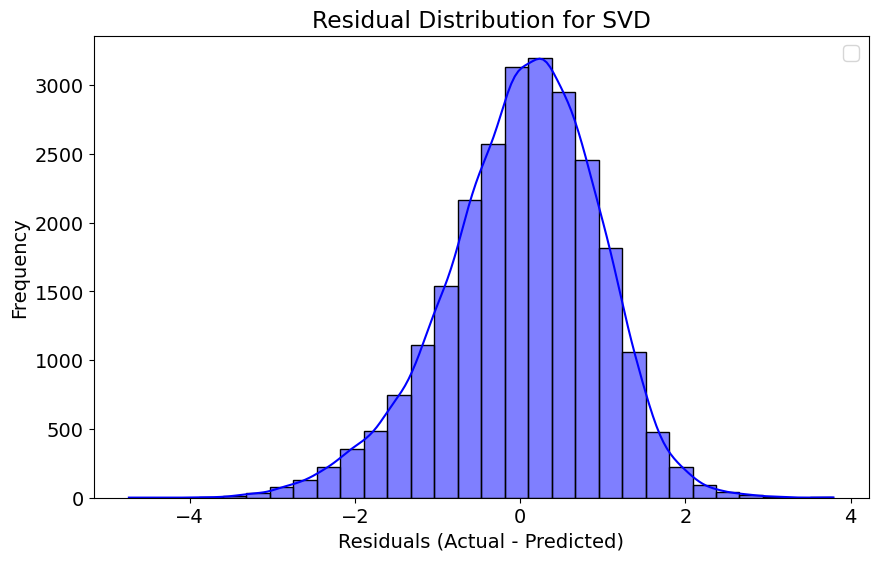

In [ ]:
plot_residual_distribution(actual_pp, predicted_pp)
# box_plot(actual, predicted)
# box_plot(actual_pp, predicted_pp)
# plot_residuals_by_frequency_wrapper(our_predictions, our_predictions_pp, "SVD", "SVD++")
# box_plot(actual, predicted, actual_pp, predicted_pp, "SVD", "SVD++")

In [ ]:
import scipy
w, p = scipy.stats.wilcoxon([
  0.9374559771984586, 0.9543470498135834, 0.9644951119728964,
  0.930479638326719, 0.9644467583962356, 0.9748150898363906,
  0.9466150253600245, 0.9742600073670603, 0.9834930319430889,
  0.9357296439093113, 0.9532534428914146, 0.9645778210626016,
  0.929209371223015, 0.9652208889370444, 0.9748400961398049,
  0.9476278144620339, 0.9744357404243342, 0.9868554198684898,
  0.9329823815972202, 0.9536741755491274, 0.9646921399441777,
  0.9279491782721054, 0.96297083725819, 0.9739740426587533,
  0.949163845941289, 0.973181602616614, 0.9829737512295204
], [
  0.9390970862235916, 0.9538746535360316, 0.9643224330205606,
  0.9301305609781363, 0.9632456785969618, 0.9730671237295981,
  0.9455664348917209, 0.9751021835498686, 0.9855958655358965,
  0.9343680689372995, 0.9535736546040953, 0.9642411709357388,
  0.9301352703374025, 0.964752056068191, 0.974106419943892,
  0.9478849906429427, 0.9735367814476227, 0.9840559580483855,
  0.9458706433166494, 0.9761293932050922, 0.9851242617006555,
  0.9290332731006261, 0.9626089027644049, 0.9762501668829788,
  0.9315604458473323, 0.9543330093648412, 0.9644983791402026
])
print("Perform Wilcoxon paired test.")
print("P-value of the difference between SVD and SVD++ is: ", p)

Perform Wilcoxon paired test.
P-value of the difference between SVD and SVD++ is:  0.6963860541582108


In [ ]:
w, p = scipy.stats.wilcoxon([
  0.9374559771984586, 0.9543470498135834, 0.9644951119728964,
  0.930479638326719, 0.9644467583962356, 0.9748150898363906,
  0.9466150253600245, 0.9742600073670603, 0.9834930319430889,
  0.9357296439093113, 0.9532534428914146, 0.9645778210626016,
  0.929209371223015, 0.9652208889370444, 0.9748400961398049,
  0.9476278144620339, 0.9744357404243342, 0.9868554198684898,
  0.9329823815972202, 0.9536741755491274, 0.9646921399441777,
  0.9279491782721054, 0.96297083725819, 0.9739740426587533,
  0.949163845941289, 0.973181602616614, 0.9829737512295204
], [
  0.9390970862235916, 0.9538746535360316, 0.9643224330205606,
  0.9301305609781363, 0.9632456785969618, 0.9730671237295981,
  0.9455664348917209, 0.9751021835498686, 0.9855958655358965,
  0.9343680689372995, 0.9535736546040953, 0.9642411709357388,
  0.9301352703374025, 0.964752056068191, 0.974106419943892,
  0.9478849906429427, 0.9735367814476227, 0.9840559580483855,
  0.9458706433166494, 0.9761293932050922, 0.9851242617006555,
  0.9290332731006261, 0.9626089027644049, 0.9762501668829788,
  0.9315604458473323, 0.9543330093648412, 0.9644983791402026
], alternative="less")
print(p)

0.660524494946003
